# Oridnary Kriging using scikit-gstat package - Crimes Dataset

https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/skgstat/Variogram.py#L1312
    
    
https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/tutorials/01_getting_started.ipynb

https://scikit-gstat.readthedocs.io/en/latest/userguide/kriging.html#spatial-interpolation

https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/skgstat/Variogram.py

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
import skgstat as skg
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


In [3]:
crimes_df = pd.read_csv("Data/crimes_processed_vehicle.csv")

In [4]:
display(crimes_df)

Latitude  Longitude  Community Area  n  location_id
0      41.644590 -87.615880              54  1            1
1      41.647037 -87.616647              54  1            2
2      41.647039 -87.616098              54  2            3
3      41.647180 -87.544241              55  1            4
4      41.647716 -87.542811              55  1            5
...          ...        ...             ... ..          ...
25463  42.022526 -87.672401               1  1        25464
25464  42.022529 -87.666324               1  1        25465
25465  42.022535 -87.673398               1  2        25466
25466  42.022536 -87.673711               1  1        25467
25467  42.022548 -87.676139               1  1        25468

[25468 rows x 5 columns]

## Splitting Data

In [5]:
# Convert columns to numpy arrays
observed_location_columns_crimes = ['Longitude','Latitude', 'Community Area']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

In [6]:
X_train_crimes, X_test_crimes, y_train_crimes, y_test_crimes = train_test_split(observed_locations_crimes,
                                                                            observed_values_crimes, test_size=0.2, random_state=0)
print(f"X_train_crimes.shape: {X_train_crimes.shape}")
print(f"X_test_crimes.shape:  {X_test_crimes.shape}")
print(f"y_train_crimes.shape: {y_train_crimes.shape}")
print(f"y_test_crimes.shape:  {y_test_crimes.shape}")

X_train_crimes.shape: (20374, 3)
X_test_crimes.shape:  (5094, 3)
y_train_crimes.shape: (20374,)
y_test_crimes.shape:  (5094,)


## Understanding distribution of clusters in train and test sets

In [15]:
x_values = [element[0] for element in X_train_crimes]
y_values = [element[1] for element in X_train_crimes]
cluster_values = [element[2] for element in X_train_crimes]

data = {
    'x': x_values,
    'y': y_values,
    'cluster_num': cluster_values
}

train_df = pd.DataFrame(data)
train_df['cluster_num'] = train_df['cluster_num'].astype('category')

x_values_test = [element[0] for element in X_test_crimes]
y_values_test = [element[1] for element in X_test_crimes]
cluster_values_test = [element[2] for element in X_test_crimes]

data_test  = {
    'x': x_values_test,
    'y': y_values_test,
    'cluster_num': cluster_values_test
}

test_df = pd.DataFrame(data_test)
test_df['cluster_num'] = test_df['cluster_num'].astype('category')

In [9]:
train_df.describe(include='all')

x             y  cluster_num
count   20374.000000  20374.000000      20374.0
unique           NaN           NaN         77.0
top              NaN           NaN         25.0
freq             NaN           NaN       1040.0
mean       41.838820    -87.668161          NaN
std         0.088524      0.058705          NaN
min        41.644590    -87.915105          NaN
25%        41.763552    -87.709835          NaN
50%        41.846372    -87.665208          NaN
75%        41.906646    -87.625739          NaN
max        42.022536    -87.525748          NaN

<Axes: >

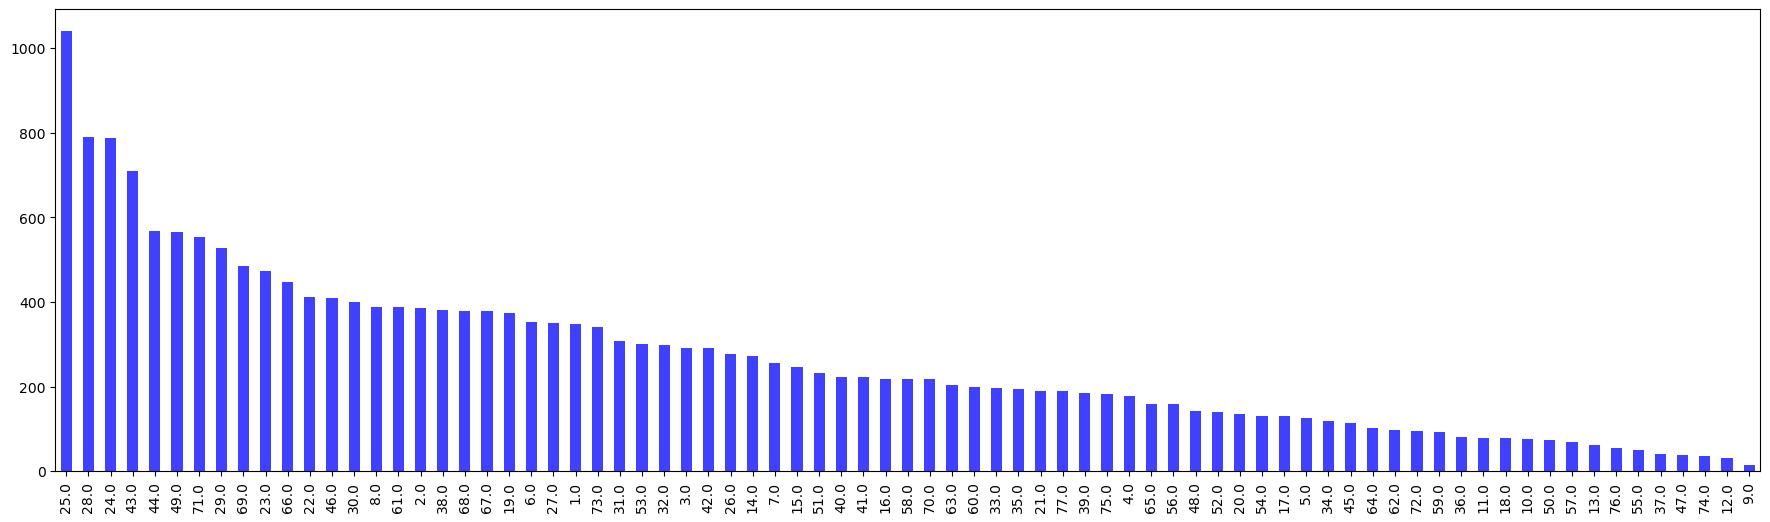

In [10]:
# Count the occurrences of each category
category_counts = train_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue', figsize=(22, 6))

In [11]:
test_df.describe(include='all')

x            y  cluster_num
count   5094.000000  5094.000000       5094.0
unique          NaN          NaN         77.0
top             NaN          NaN         25.0
freq            NaN          NaN        278.0
mean      41.838853   -87.668812          NaN
std        0.088203     0.058717          NaN
min       41.647716   -87.906547          NaN
25%       41.764212   -87.710435          NaN
50%       41.847612   -87.665034          NaN
75%       41.907087   -87.625856          NaN
max       42.022548   -87.525270          NaN

<Axes: >

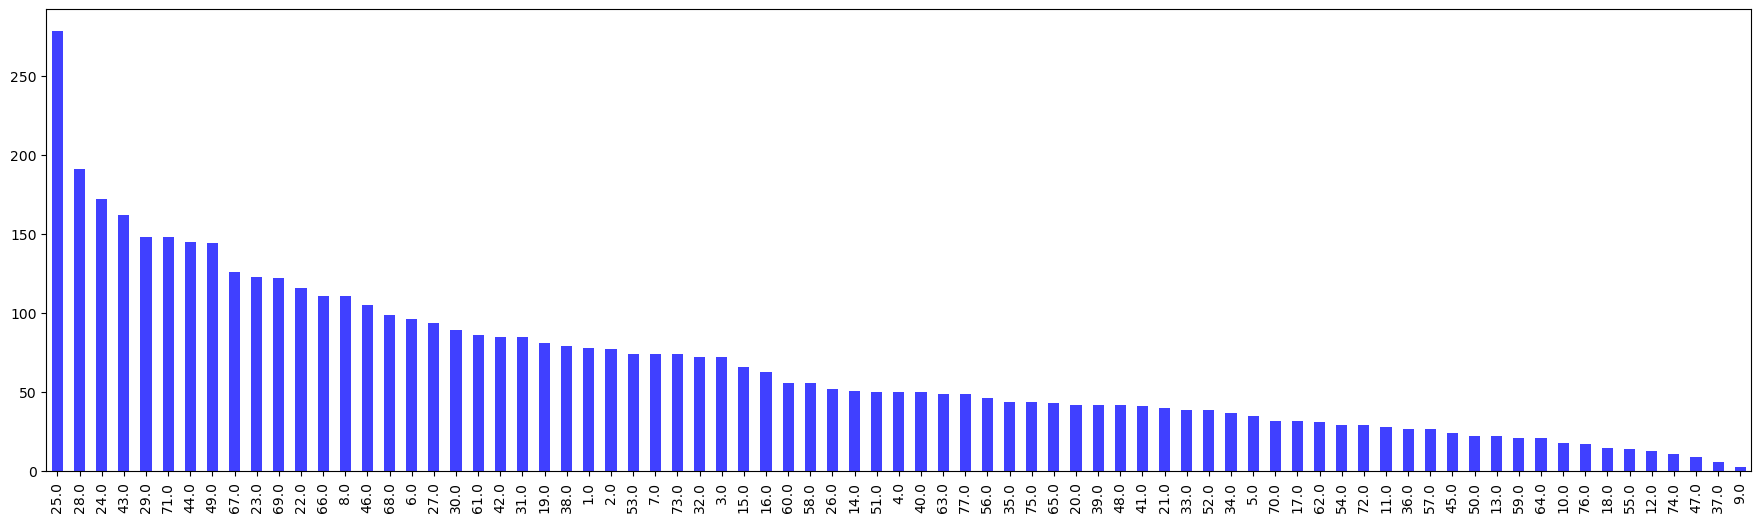

In [12]:
# Count the occurrences of each category
category_counts = test_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue', figsize=(22, 6))

In [7]:
from scipy.spatial import distance_matrix

# Calculate the pairwise distance matrix
dist_matrix = distance_matrix(X_train_crimes, X_train_crimes)

# Find the maximum pairwise distance
max_pairwise_distance = np.max(dist_matrix)

# Decide on a proportion of the maximum distance for maxlag
proportion = 0.5  # 50% of the maximum distance
maxlag = max_pairwise_distance * proportion

print("Maximum Pairwise Distance:", max_pairwise_distance)
print("Maxlag set to:", maxlag)

Maximum Pairwise Distance: 76.00001908071634
Maxlag set to: 38.00000954035817


## Spatial K-Fold Cross Validation

### Examining fit between theoratical and experimental variogram using RMSE

Before we proceed with cross validation, in Kriging, we can use the variogram as an indicator in determining if our model will perform well. This is done by analysing the fit between the theoratical variogram and experimental variogram. As without a good fit, the semi-variance value used for interpolation later on would not be optimal as well.

There are 6 different theoratical variogram models we can choose from, and here we can do a visual inspection of whether each of these theoratical model fits the experimental variogram, as well as calculate the RMSE as a numerical comparison across the different theoratical models. 

We can see that all 6 models is able to describe the experimental variogram more or less equally well in terms of RMSE, since the differences in the values are rather insignificant. However, this arises a problem, whereby some of these models actually describe fundamentally different spatial properties but yet the RMSE values are almost the same. Hence, using these indicators to decide which theoratical model would have the best fit would not be sufficent and cross validation should be done, where we fit the variogram with a different model and then consider the interpolated values.

### Spherical

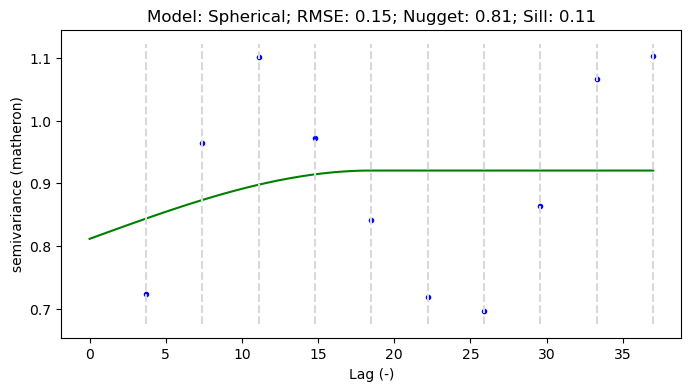

In [15]:
V = skg.Variogram(X_train_crimes, y_train_crimes, fit_method = 'ml', model = 'spherical', use_nugget = True, maxlag = maxlag)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Model: Spherical; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

### Exponential

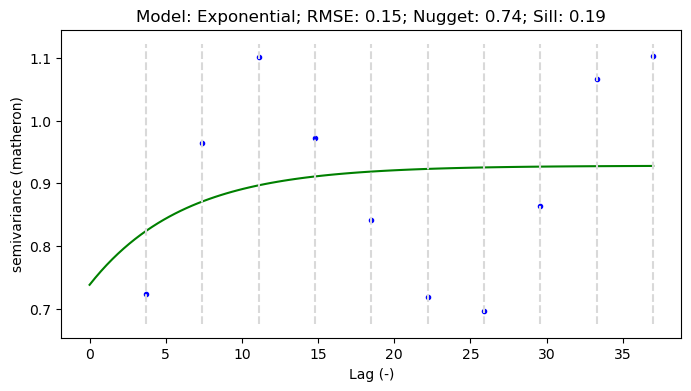

In [14]:
V = skg.Variogram(X_train_crimes, y_train_crimes, fit_method = 'ml', model = 'exponential', use_nugget = True, maxlag = maxlag)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Model: Exponential; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

### Gaussian

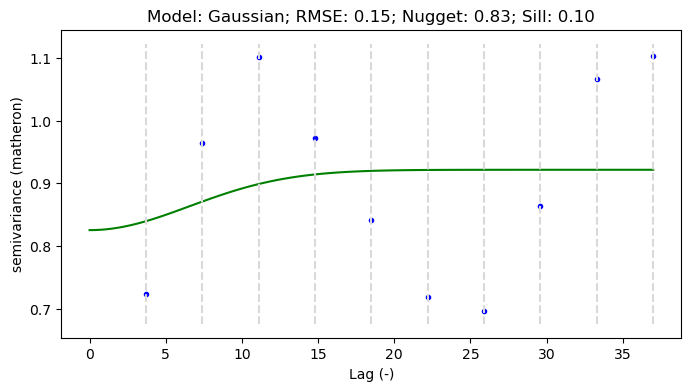

In [16]:
V = skg.Variogram(X_train_crimes, y_train_crimes, fit_method = 'ml', model = 'gaussian', use_nugget = True, maxlag = maxlag)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Model: Gaussian; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show()

### Matern

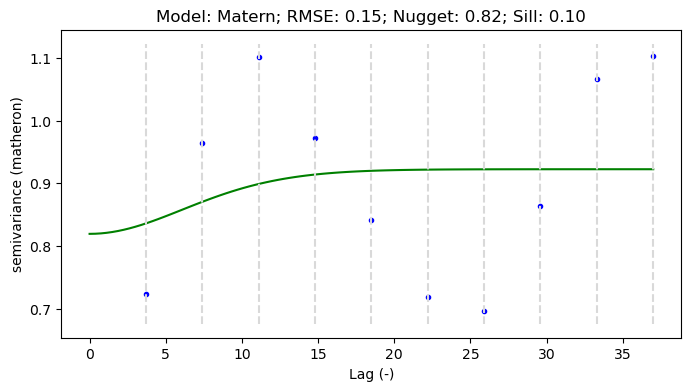

In [11]:
V = skg.Variogram(X_train_crimes, y_train_crimes, fit_method = 'ml', model = 'matern', use_nugget = True, maxlag = maxlag)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Model: Matern; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show()

### Stable

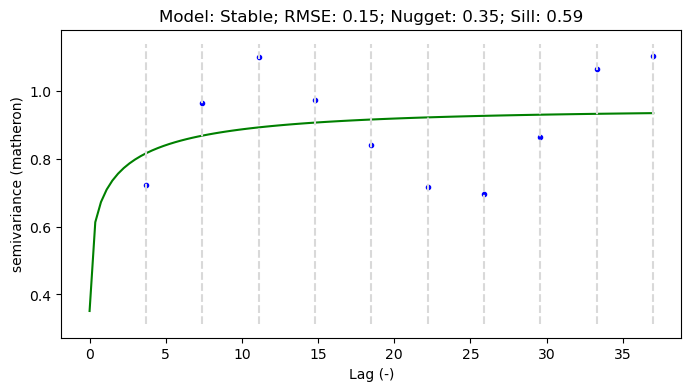

In [9]:
V = skg.Variogram(X_train_crimes, y_train_crimes, fit_method = 'ml', model = 'stable', use_nugget = True, maxlag = maxlag)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Model: Stable; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show()

### Cubic

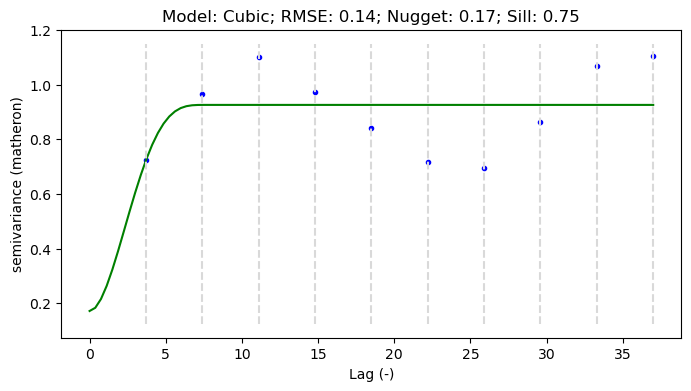

In [10]:
V = skg.Variogram(X_train_crimes, y_train_crimes, fit_method = 'ml', model = 'cubic', use_nugget = True, maxlag = maxlag)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Model: Cubic; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
plt.show()

### K-Fold Cross Validation

Here, we will be doing K-Fold Cross validation, whereby for each of the 6 theoratical model, the training data is split into K Folds. We will fit the variogram on K-1 Folds, and then interpolate with the remaining fold. A cross valdiation score for this split will be calculated based on the actual values and the interpolated values, and we will repeat this for K times. 

Afterwards, we will get the mean cross validation score, which is the mean of the cross validation scores obtained in each split. We will compute the score with 3 different metrics, namely: RMSE, Mean Absolute Error, Mean Absolute Percentage Error to conduct a more comprehensive analysis. 

In [8]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]
cluster_num_data_train = [inner_list[2] for inner_list in X_train_crimes]

### Re-Fit variogram in each K-Fold?

In [13]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}
models_list = ['stable','exponential', 'gaussian', 'matern', 'cubic', 'spherical']
start_time = time.time()
#For each possible theoratical model, conduct K-Fold CV
for model in models_list:
     
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 5)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []
    cv_scores_sigma = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        V_train = skg.Variogram(combined_array, train_data['Z'], fit_method = 'ml', use_nugget = True, maxlag = maxlag)

        # Fit Ordinary Kriging model
        OK = skg.OrdinaryKriging(V_train, mode='exact')

        # Predict at test locations
        z_pred_train = OK.transform(test_data['X'], test_data['Y'])
        
        valid_idx = ~np.isnan(z_pred_train)
        y_true_clean = test_data['Z'][valid_idx]
        y_pred_clean = z_pred_train[valid_idx]
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
        r2 = r2_score(y_true_clean, y_pred_clean)
        sigma = np.mean(OK.sigma[valid_idx])
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        cv_scores_sigma.append(sigma)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    mean_validation_score_sigma = np.mean(cv_scores_sigma)
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[model] = {
        "Mean CV Score MAE" : mean_validation_score_mae,
        "Mean CV Score RMSE" : mean_validation_score_rmse,
        "Mean CV Score MAPE" : mean_validation_score_mape,
        "Mean CV Score R Squared": mean_validation_score_r2,
        "Mean CV Score Kriging Var" : mean_validation_score_sigma
    }

end_time = time.time()
# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric
# Initialize a dictionary to track the smallest scores and corresponding models
smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "power": None},
    "Mean CV Score RMSE": {"value": float('inf'), "power": None},
    "Mean CV Score MAPE": {"value": float('inf'), "power": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "power": None},
    "Mean CV Score Kriging Var": {"value": float('inf'), "model": None}
}
# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in {info['model']} model.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in {info['model']} model.")
    
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

stable  exponential  gaussian    matern  \
Mean CV Score MAE          0.512445     0.512445  0.512445  0.512445   
Mean CV Score RMSE         1.139856     1.139856  1.139856  1.139856   
Mean CV Score MAPE         0.370222     0.370222  0.370222  0.370222   
Mean CV Score R Squared   -0.501239    -0.501239 -0.501239 -0.501239   
Mean CV Score Kriging Var  0.242886     0.242886  0.242886  0.242886   

                              cubic  spherical  
Mean CV Score MAE          0.512445   0.512445  
Mean CV Score RMSE         1.139856   1.139856  
Mean CV Score MAPE         0.370222   0.370222  
Mean CV Score R Squared   -0.501239  -0.501239  
Mean CV Score Kriging Var  0.242886   0.242886

The smallest Mean CV Score MAE is 0.512445488847421, found in stable model.
The smallest Mean CV Score RMSE is 1.1398556879246036, found in stable model.
The smallest Mean CV Score MAPE is 0.37022171575519813, found in stable model.
The largest Mean CV Score R Squared is -0.501239099585061, found in stable model.
The smallest Mean CV Score Kriging Var is 0.24288610479992934, found in stable model.
Training Computation Time: 6739.05 seconds


## Evaluation of Model (Testing Chosen model)

### Performance Metrics of Model

In [8]:
# Dataframe manipulation to fit Variogram paramaters
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]
data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
})
combined_array = np.array([list(pair) for pair in zip(data['X'], data['Y'])])

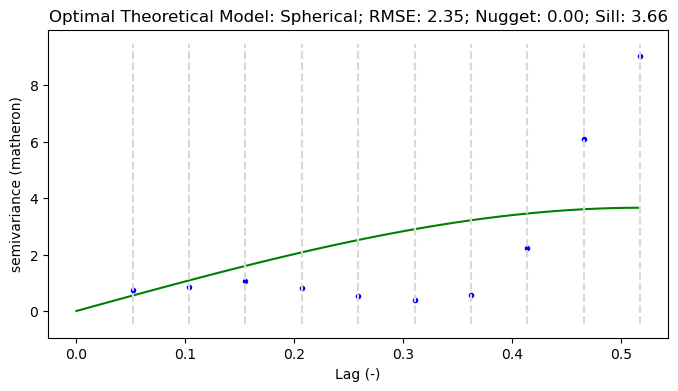

In [9]:
V_test = skg.Variogram(combined_array, y_train_crimes,model = 'spherical', fit_method = 'ml', use_nugget = True, maxlag = maxlag)
fig = V_test.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Optimal Theoretical Model: Spherical; RMSE: {V_test.rmse:.2f}; Nugget: {V_test.describe()["nugget"]:.2f}; Sill: {V_test.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

In [10]:
# Using list comprehension
x_data_test = [inner_list[0] for inner_list in X_test_crimes]
y_data_test = [inner_list[1] for inner_list in X_test_crimes]

data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_crimes
})
start_time = time.time()
# Fit Ordinary Kriging model
OK = skg.OrdinaryKriging(V_test, mode='exact')

# Predict at test locations
z_pred_test = OK.transform(data['X'], data['Y'])
        
# Calculate Metrics and append the validation score for each split into cv_scores_metric
rmse = np.sqrt(mean_squared_error(data['Z'], z_pred_test))
mae = mean_absolute_error(data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(data['Z'], z_pred_test)
r2 = r2_score(data['Z'], z_pred_test)
sigma = np.mean(OK.sigma)
end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print("Mean of Kriging Var:", sigma)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.3916898293039084
RMSE: 1.0863714541262641
MAPE: 0.2554978249999255
R Squared: -0.39040159805334174
Mean of Kriging Var: 0.007593374490289054
Testing Computation Time: 34.46 seconds


### Plotting Spatial Interpolation of entire area with Model

In [11]:
# Convert columns to numpy arrays
observed_location_columns_crimes = ['Longitude','Latitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

In [12]:
from scipy.spatial import distance_matrix

# Calculate the pairwise distance matrix
dist_matrix = distance_matrix(observed_locations_crimes, observed_locations_crimes)

# Find the maximum pairwise distance
max_pairwise_distance = np.max(dist_matrix)

# Decide on a proportion of the maximum distance for maxlag
proportion = 0.5  # 50% of the maximum distance
maxlag_test = max_pairwise_distance * proportion

print("Maximum Pairwise Distance:", max_pairwise_distance)
print("Maxlag set to:", maxlag_test)

Maximum Pairwise Distance: 0.5176311998335419
Maxlag set to: 0.25881559991677094


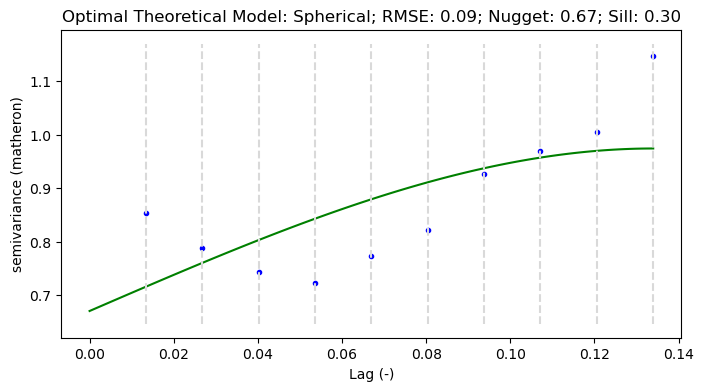

Sample variance: 0.83   Variogram sill: 0.30


In [13]:
V = skg.Variogram(observed_locations_crimes, observed_values_crimes,model = 'spherical',fit_method = 'ml', use_nugget = True, maxlag = maxlag_test)
fig = V.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'Optimal Theoretical Model: Spherical; RMSE: {V.rmse:.2f}; Nugget: {V.describe()["nugget"]:.2f}; Sill: {V.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

print('Sample variance: %.2f   Variogram sill: %.2f' % (observed_values_crimes.flatten().var(), V.describe()['sill']))

In [8]:
ok = skg.OrdinaryKriging(V, mode='exact')
# build the target grid
x = observed_locations_crimes[:,0]
y = observed_locations_crimes[:,1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

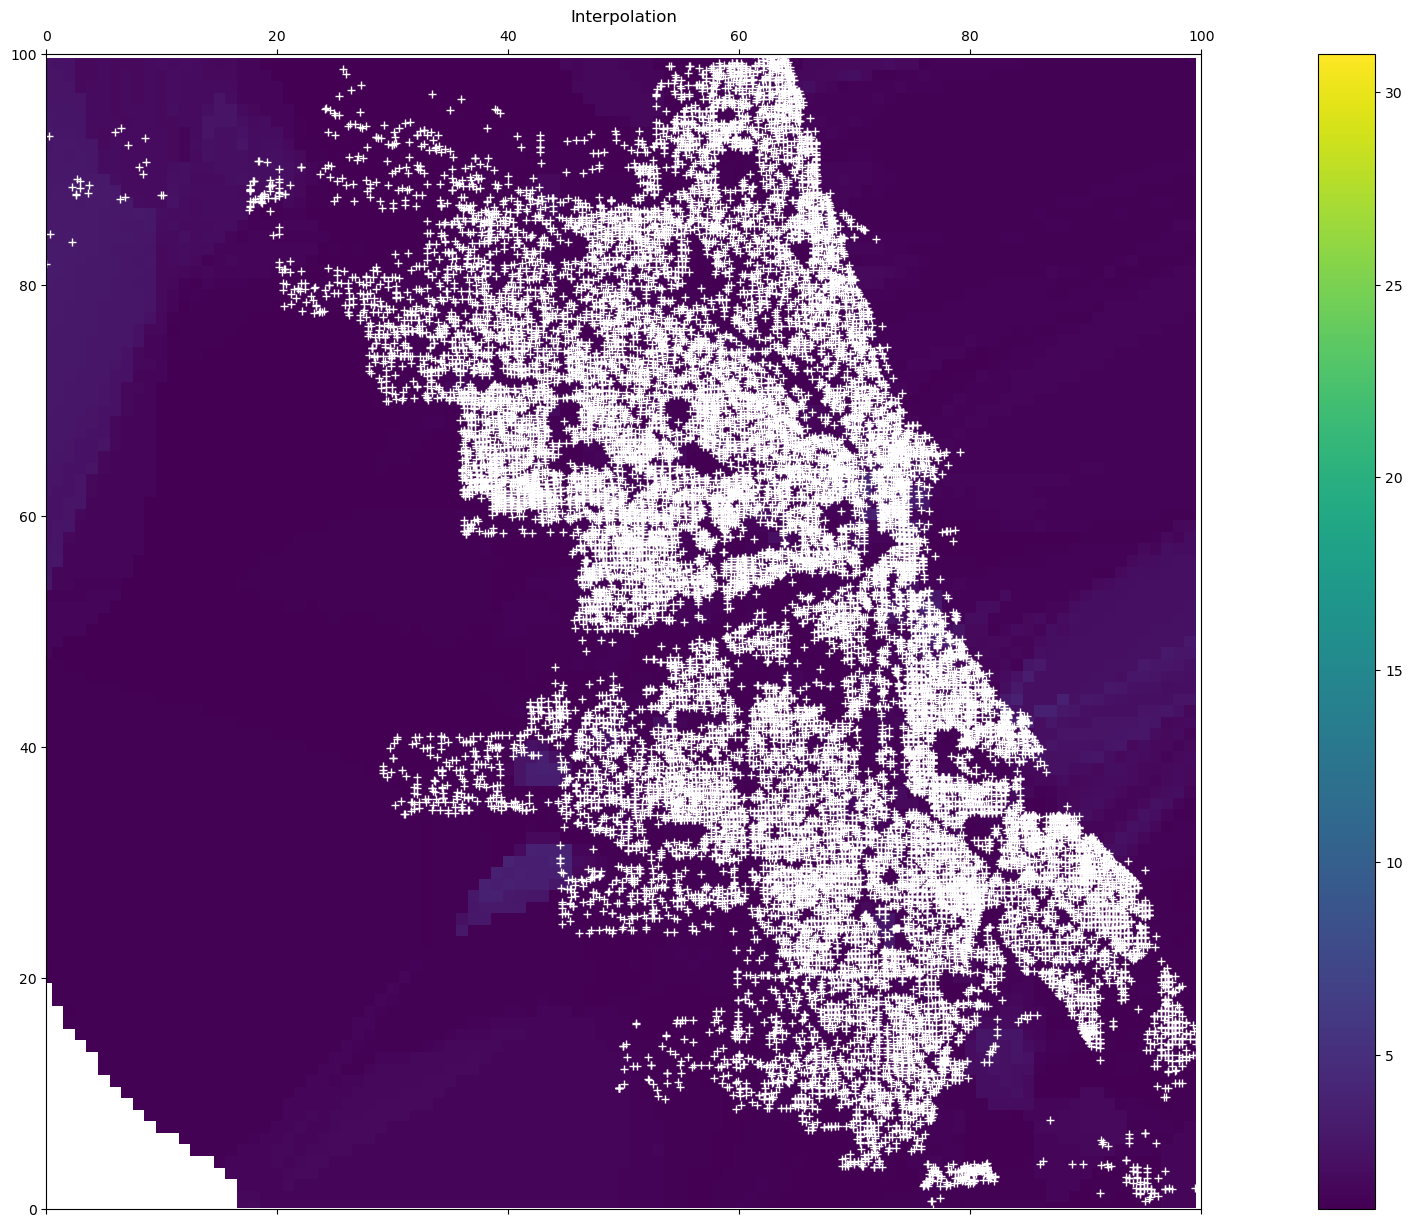

In [35]:
import matplotlib.pyplot as plt

# Adjusting the size of the plot
fig, ax = plt.subplots(figsize=(30, 15))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

# Plotting the interpolation
art = ax.matshow(field.T, origin='lower', cmap='viridis', vmin=observed_values_crimes.min(), vmax=observed_values_crimes.max())
ax.set_title('Interpolation')
ax.plot(x_, y_, '+w')
ax.set_xlim((0,100))
ax.set_ylim((0,100))
plt.colorbar(art)

plt.show()


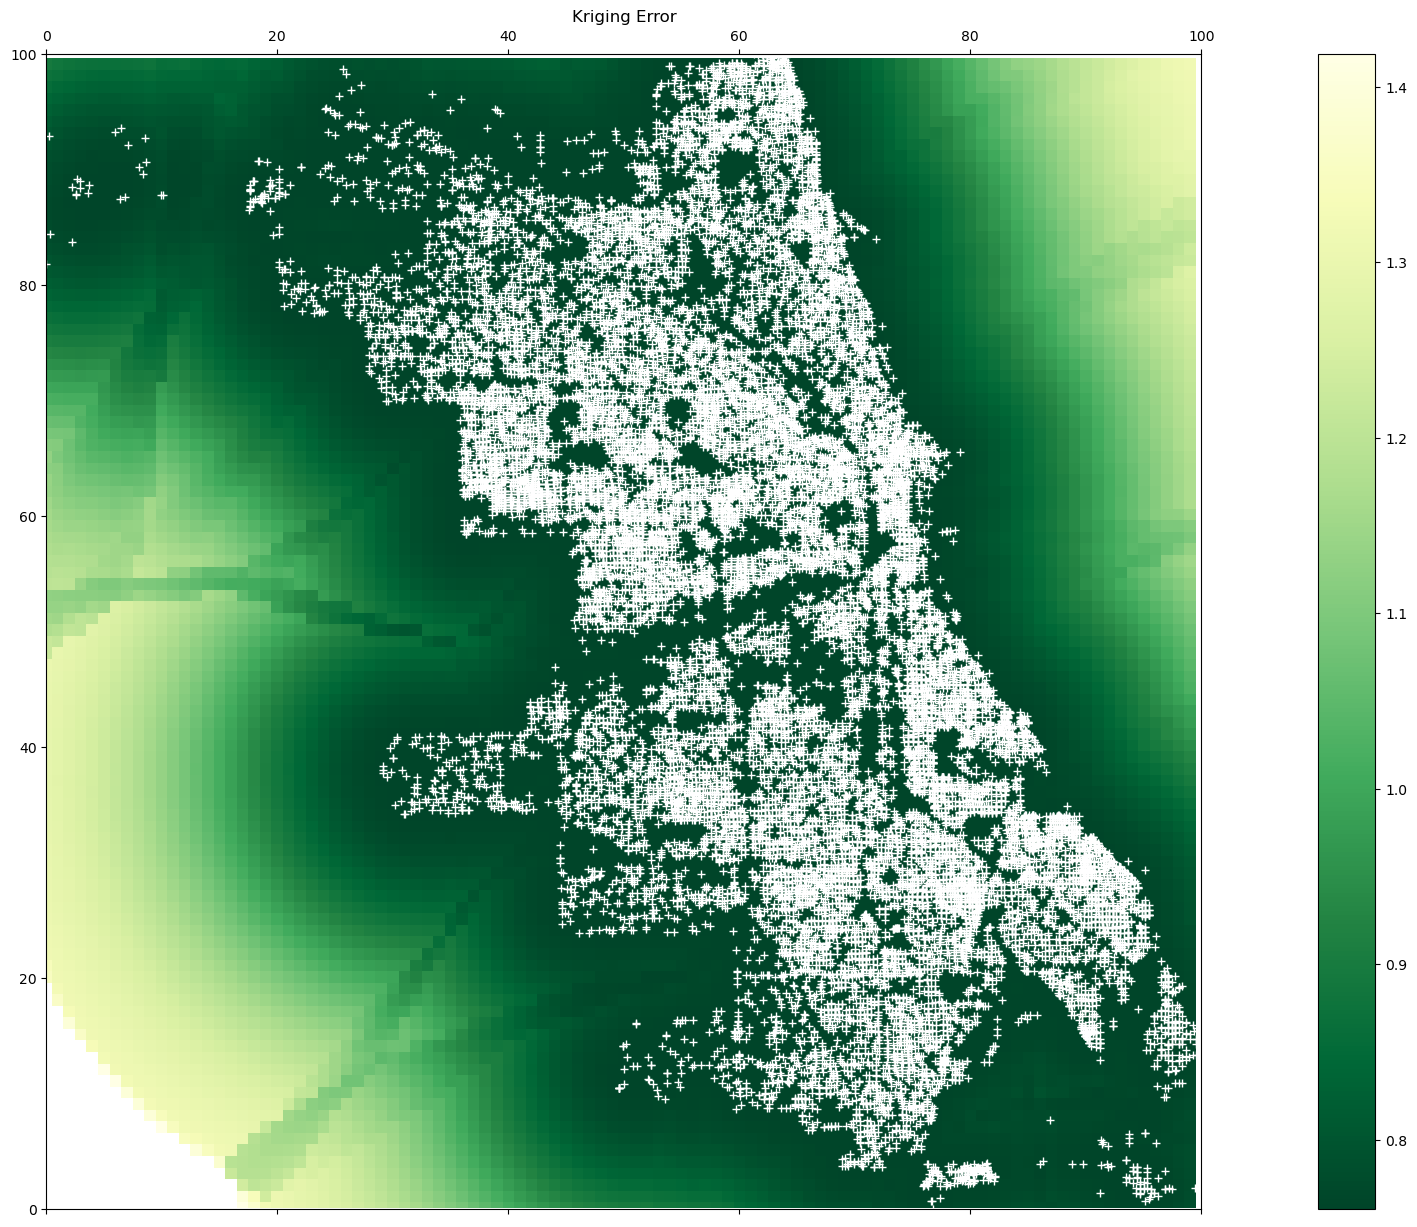

In [36]:
import matplotlib.pyplot as plt

# Adjusting the size of the plot
fig, ax = plt.subplots(figsize=(30, 15))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

# Plotting the Kriging error
art = ax.matshow(s2.T, origin='lower', cmap='YlGn_r')
ax.set_title('Kriging Error')
plt.colorbar(art)
ax.plot(x_, y_, '+w')
ax.set_xlim((0,100))
ax.set_ylim((0,100))

plt.show()


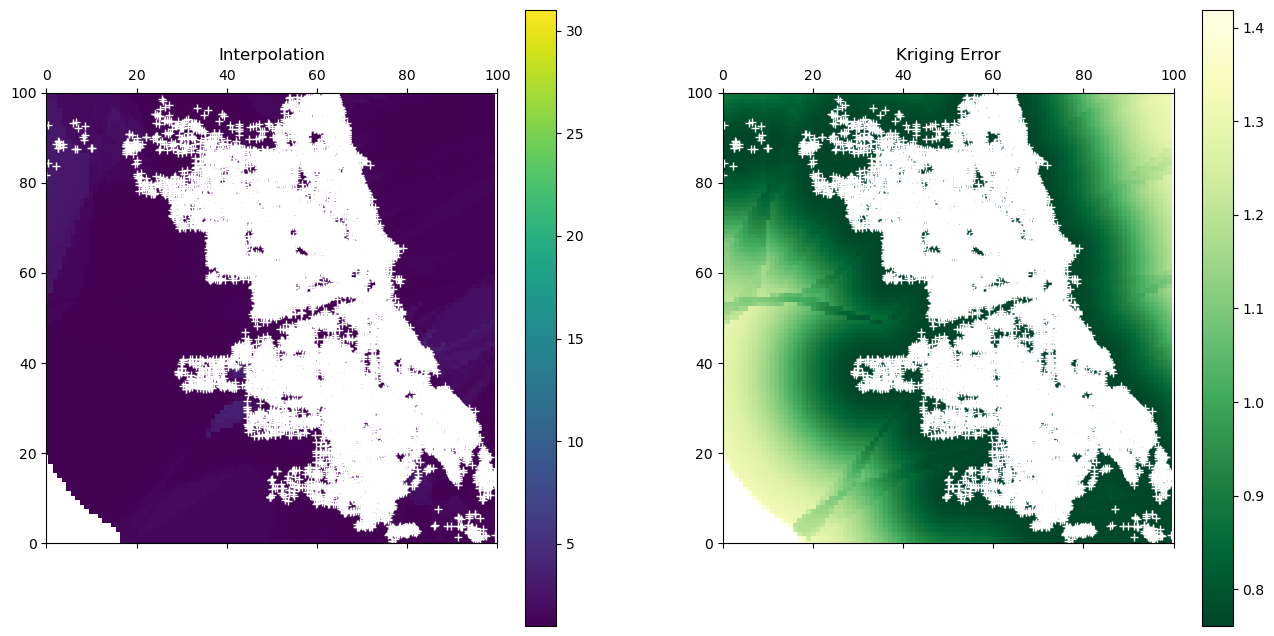

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='viridis', vmin=observed_values_crimes.min(), vmax=observed_values_crimes.max())
axes[0].set_title('Interpolation')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

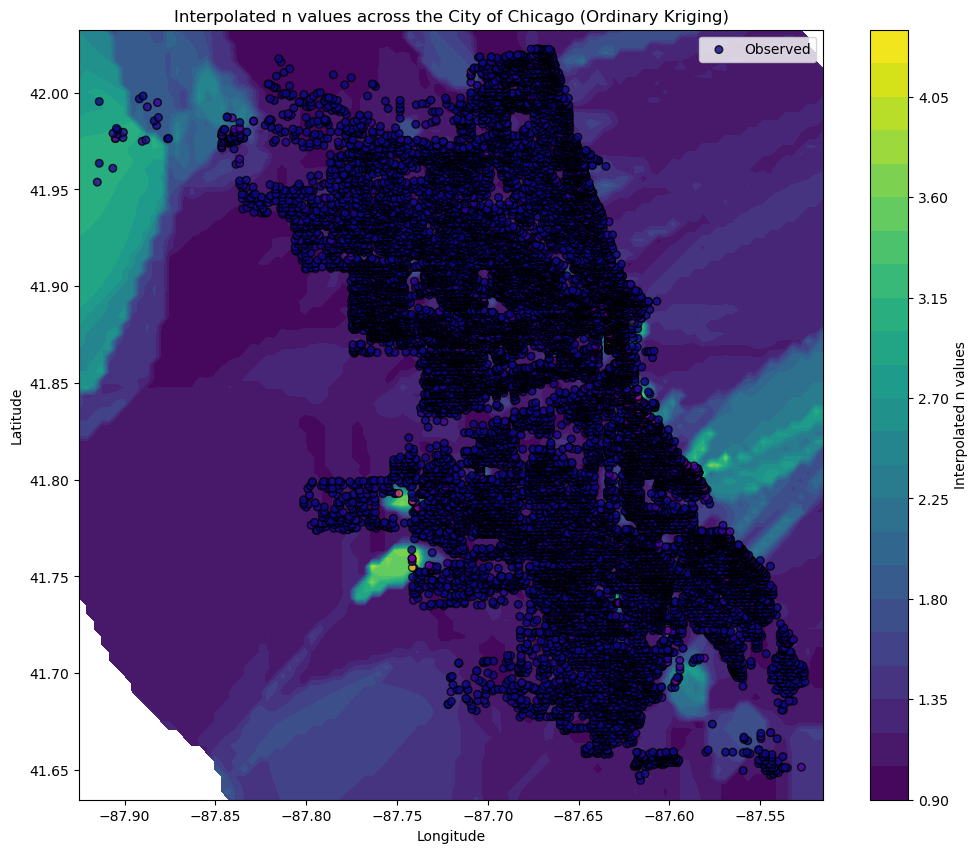

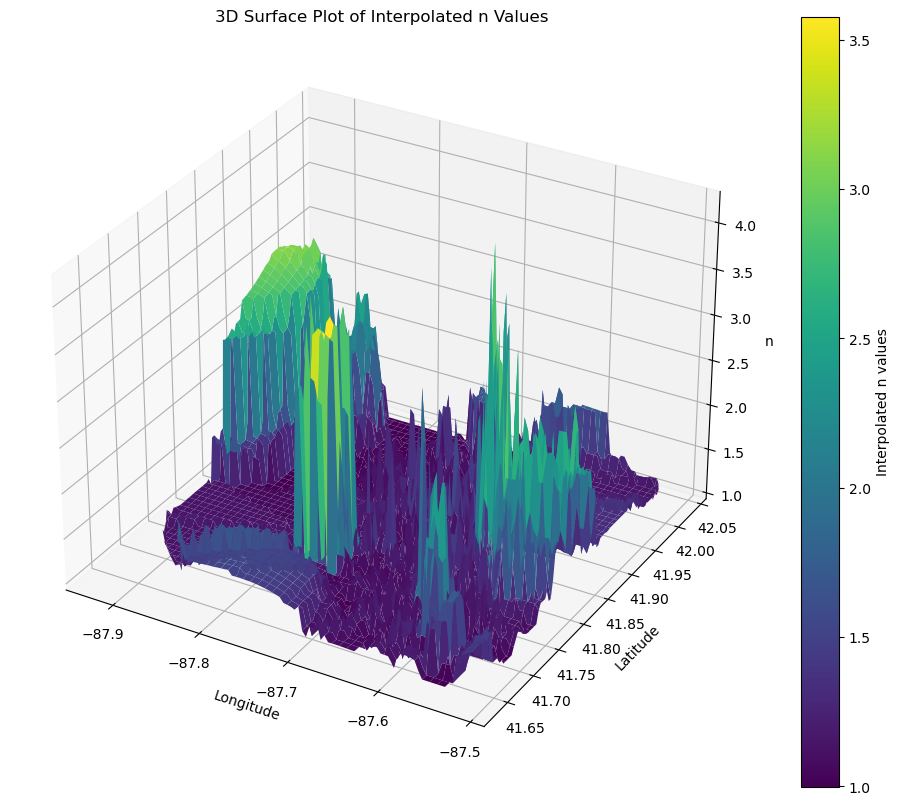

In [10]:
# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations_crimes[:, 0].min() - buffer, observed_locations_crimes[:, 0].max() + buffer
y_min, y_max = observed_locations_crimes[:, 1].min() - buffer, observed_locations_crimes[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = ok.transform(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)


fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=30)
plt.colorbar(label='Interpolated n values')
plt.scatter(crimes_df['Longitude'],crimes_df['Latitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s=30, alpha=0.8)

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Interpolated n values across the City of Chicago (Ordinary Kriging)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated n values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('n')
ax.set_title('3D Surface Plot of Interpolated n Values')
plt.show()


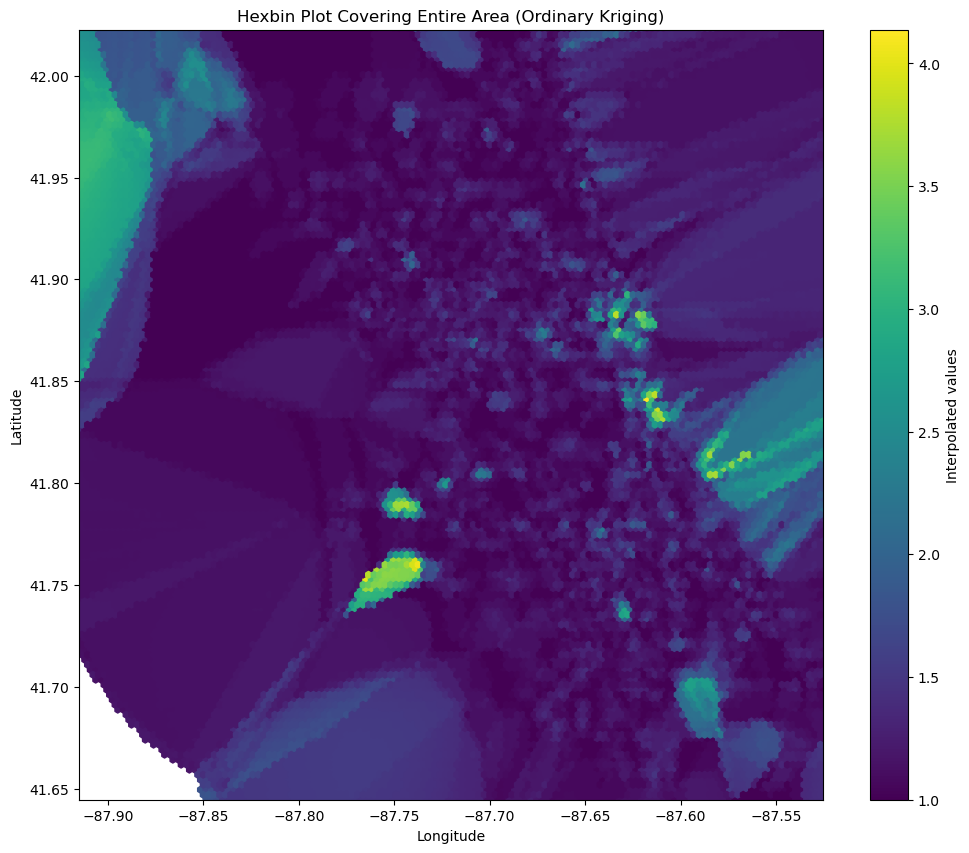

Spatial Interpolation Computation Time: 130.48 seconds


In [11]:
# Determine the minimum and maximum values for Latitude and Longitude
observed_location_columns_crimes = ['Longitude', 'Latitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Determine the minimum and maximum values for Latitude and Longitude
lat_min, lat_max = crimes_df['Latitude'].min(), crimes_df['Latitude'].max()
lon_min, lon_max = crimes_df['Longitude'].min(), crimes_df['Longitude'].max()

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Interpolate values
interpolated_values = ok.transform(combined_array)

end_time_interpolation = time.time()  # End timing spatial interpolation
# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=135, cmap='viridis', extent=(lon_min, lon_max, lat_min, lat_max))
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lon_min, lon_max)  # Corrected for longitude
plt.ylim(lat_min, lat_max)  # Corrected for latitude

plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')  # Corrected label
plt.title('Hexbin Plot Covering Entire Area (Ordinary Kriging)')
plt.show()
print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

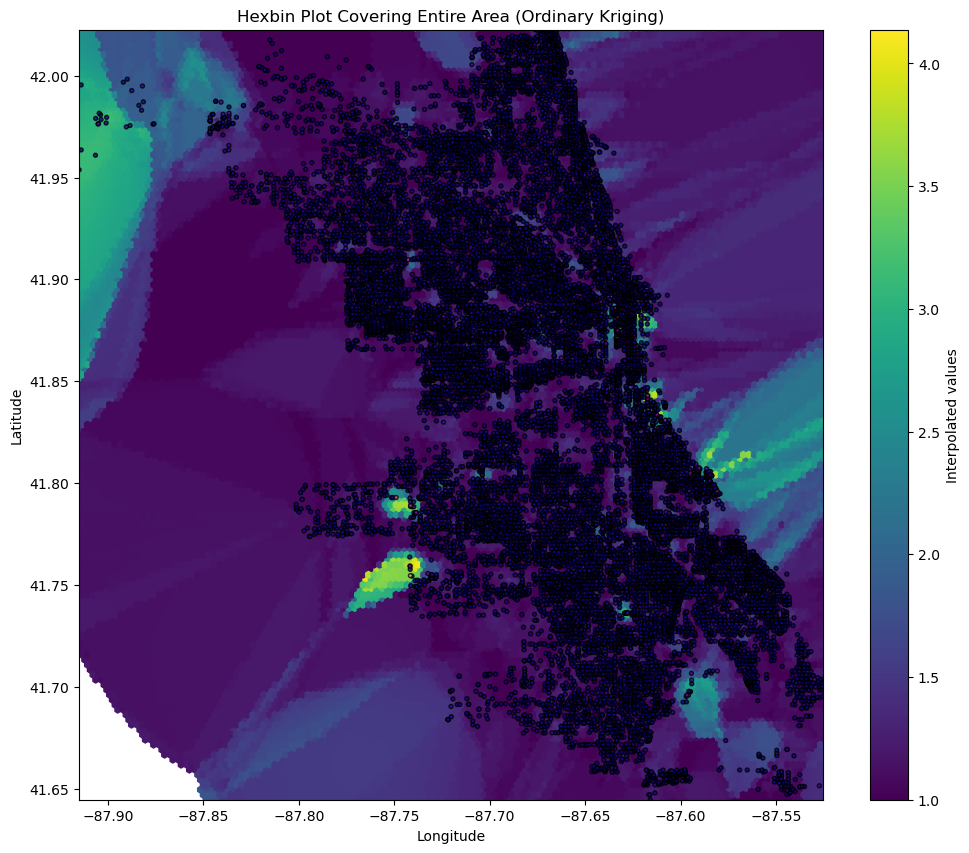

Spatial Interpolation Computation Time: 129.92 seconds


In [13]:
# Determine the minimum and maximum values for Latitude and Longitude
observed_location_columns_crimes = ['Longitude', 'Latitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Determine the minimum and maximum values for Latitude and Longitude
lat_min, lat_max = crimes_df['Latitude'].min(), crimes_df['Latitude'].max()
lon_min, lon_max = crimes_df['Longitude'].min(), crimes_df['Longitude'].max()

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Interpolate values
interpolated_values = ok.transform(combined_array)

end_time_interpolation = time.time()  # End timing spatial interpolation
# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=135, cmap='viridis', extent=(lon_min, lon_max, lat_min, lat_max))
plt.scatter(crimes_df['Longitude'], crimes_df['Latitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s= 8, alpha=0.8)
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lon_min, lon_max)  # Corrected for longitude
plt.ylim(lat_min, lat_max)  # Corrected for latitude

plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')  # Corrected label
plt.title('Hexbin Plot Covering Entire Area (Ordinary Kriging)')
plt.show()
print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")